In [32]:
import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Built with CUDA:", torch.version.cuda)
print("GPU detected:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")


PyTorch version: 2.5.1+cu121
CUDA available: True
Built with CUDA: 12.1
GPU detected: NVIDIA GeForce RTX 4060


In [33]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import os, glob
import hdbscan

# 1. Load ResNet50 model
model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1]) # Remove last layer for classification so we keep features
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

c:\Users\Kopan\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Kopan\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [35]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Obtain image embeddings
print("Obtaining Image embeddings")
embeddings = []
data_path = os.path.join(os.getcwd(), "Data", "unl", "unl_PNG","*.png")
for path in glob.glob(data_path):
    img = Image.open(path).convert("RGB")
    x = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        feat = model(x).squeeze().cpu().numpy()
    embeddings.append(feat)
print("Completed Image embeddings")

# Run HDBScan classifier
print("Classifying Image embeddings")
clusterer = hdbscan.HDBSCAN(min_cluster_size=30)
labels = clusterer.fit_predict(embeddings)
print("Done")

c:\Users\Kopan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Kopan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


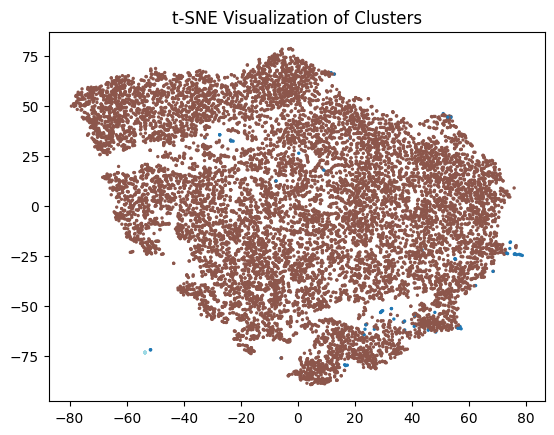

In [39]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Visualise the classifications.
flattened_embeddings = np.array(embeddings)
reduced = TSNE(n_components=2, perplexity=30).fit_transform(flattened_embeddings)
plt.scatter(reduced[:,0], reduced[:,1], c=labels, cmap="tab20", s=2)
plt.title("t-SNE Visualization of Clusters")
plt.show()

In [40]:
import pandas as pd
import os

paths = glob.glob(data_path)
df = pd.DataFrame({
    "image_path": paths,
    "pseudo_label": labels
})
df.to_csv("pseudo_labels.csv", index=False)
